In [1]:
# Load packages

# General math packages
import numpy as np
from scipy.integrate import odeint
import math

# Visualization
import matplotlib.pyplot as plt

# Data Science
import tensorflow as tf

## Create model for pendulum behaviour + generate data

In [2]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Function that returns dtheta/dt.
def model(theta, t, bm, l):
    g = 9.81
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1)
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt


In [3]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Inputs
b = 0.5
l = 1
m = 1
bm = b/m
actual_params = [b/m, l]
actual_theta_0 = [math.pi/2, 0]
t_min = 0
t_max = 5
t_step = 0.05
t = np.arange(t_min, t_max + t_step, t_step)

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

In [4]:
# Generate noise
noise_sd = 0.3
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

In [5]:
# Generate training dataset

# Adjusting the time range
t_max_new = 5  # Set the maximum time to 5 seconds
t_train = np.arange(t_min, t_max_new + t_step, t_step)

# Finding the index corresponding to the first second
index_train = int(t_max_new / t_step) + 1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_train = actual_theta[:index_train]

## Basic neural network considering only the current point for the model

In [23]:
# Define a custom sine activation function
def sin_activation(x):
    return tf.sin(x)

# Define the neural network architecture
class NNsin(tf.keras.Model):
    def __init__(self, l2_reg=0.01):
        super(NNsin, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.dense2 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.dense3 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.out = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))  # Output: theta1
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta
    
# Define the neural network architecture
class NNtanh_reg(tf.keras.Model):
    def __init__(self, l2_reg=0.1):
        super(NNtanh_reg, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(64, activation='tanh')
        self.out = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))  # Output: theta1
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta
    
# Define the neural network architecture
class NNtanh(tf.keras.Model):
    def __init__(self):
        super(NNtanh, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(64, activation='tanh')
        self.out = tf.keras.layers.Dense(1)  # Output: theta1
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta

In [9]:
# Define the loss function
def loss_fn(model_nn, t_train_tensor, actual_theta_noisy_train_tensor):
    # Data loss: Mean Squared Error between predicted and noisy data
    theta_pred = model_nn(t_train_tensor)
    total_loss = tf.reduce_mean(tf.square(theta_pred - actual_theta_noisy_train_tensor))
    return total_loss

In [11]:
# Initialize the neural network
model_nn_sin = NNsin()

# Convert training data to tensorflow tensors
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
t_train_tensor = tf.reshape(t_train_tensor, (-1, 1))

actual_theta_noisy_train_tensor = tf.convert_to_tensor(actual_theta_noisy_train[:,0], dtype=tf.float32)
actual_theta_noisy_train_tensor = tf.reshape(actual_theta_noisy_train_tensor, shape=(101, 1))

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model_nn_sin, t_train_tensor, actual_theta_noisy_train_tensor)
    grads = tape.gradient(loss, model_nn_sin.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_nn_sin.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# After training, the model should be able to predict theta values that adhere to the differential equations

Epoch 0, Loss: 0.9676169157028198


In [28]:
# Initialize the neural network
model_nn_tanh = NNtanh()

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model_nn_tanh, t_train_tensor, actual_theta_noisy_train_tensor)
    grads = tape.gradient(loss, model_nn_tanh.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_nn_tanh.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# After training, the model should be able to predict theta values that adhere to the differential equations

Epoch 0, Loss: 0.7375696301460266
Epoch 100, Loss: 0.33957210183143616
Epoch 200, Loss: 0.2033170759677887
Epoch 300, Loss: 0.17212724685668945
Epoch 400, Loss: 0.11905059218406677
Epoch 500, Loss: 0.10447380691766739
Epoch 600, Loss: 0.09436123818159103
Epoch 700, Loss: 0.0804404765367508
Epoch 800, Loss: 0.06459369510412216
Epoch 900, Loss: 0.06284146755933762
Epoch 1000, Loss: 0.06224023178219795
Epoch 1100, Loss: 0.061757348477840424
Epoch 1200, Loss: 0.0613635890185833
Epoch 1300, Loss: 0.0610426589846611
Epoch 1400, Loss: 0.06077147647738457
Epoch 1500, Loss: 0.06052378565073013
Epoch 1600, Loss: 0.06027509644627571
Epoch 1700, Loss: 0.05999591946601868
Epoch 1800, Loss: 0.05965999886393547
Epoch 1900, Loss: 0.05924927070736885
Epoch 2000, Loss: 0.05878053233027458
Epoch 2100, Loss: 0.05817963927984238
Epoch 2200, Loss: 0.05755898356437683
Epoch 2300, Loss: 0.05691633000969887
Epoch 2400, Loss: 0.05657248944044113
Epoch 2500, Loss: 0.05560775473713875
Epoch 2600, Loss: 0.05495449

In [24]:
# Initialize the neural network
model_nn_tanh_reg = NNtanh_reg()

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model_nn_tanh_reg, t_train_tensor, actual_theta_noisy_train_tensor)
    grads = tape.gradient(loss, model_nn_tanh_reg.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_nn_tanh_reg.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# After training, the model should be able to predict theta values that adhere to the differential equations

Epoch 0, Loss: 0.6380615234375
Epoch 100, Loss: 0.2863032817840576
Epoch 200, Loss: 0.20465749502182007
Epoch 300, Loss: 0.16864478588104248
Epoch 400, Loss: 0.11067277193069458
Epoch 500, Loss: 0.09565886110067368
Epoch 600, Loss: 0.07540357857942581
Epoch 700, Loss: 0.06393783539533615
Epoch 800, Loss: 0.061316750943660736
Epoch 900, Loss: 0.06058238819241524


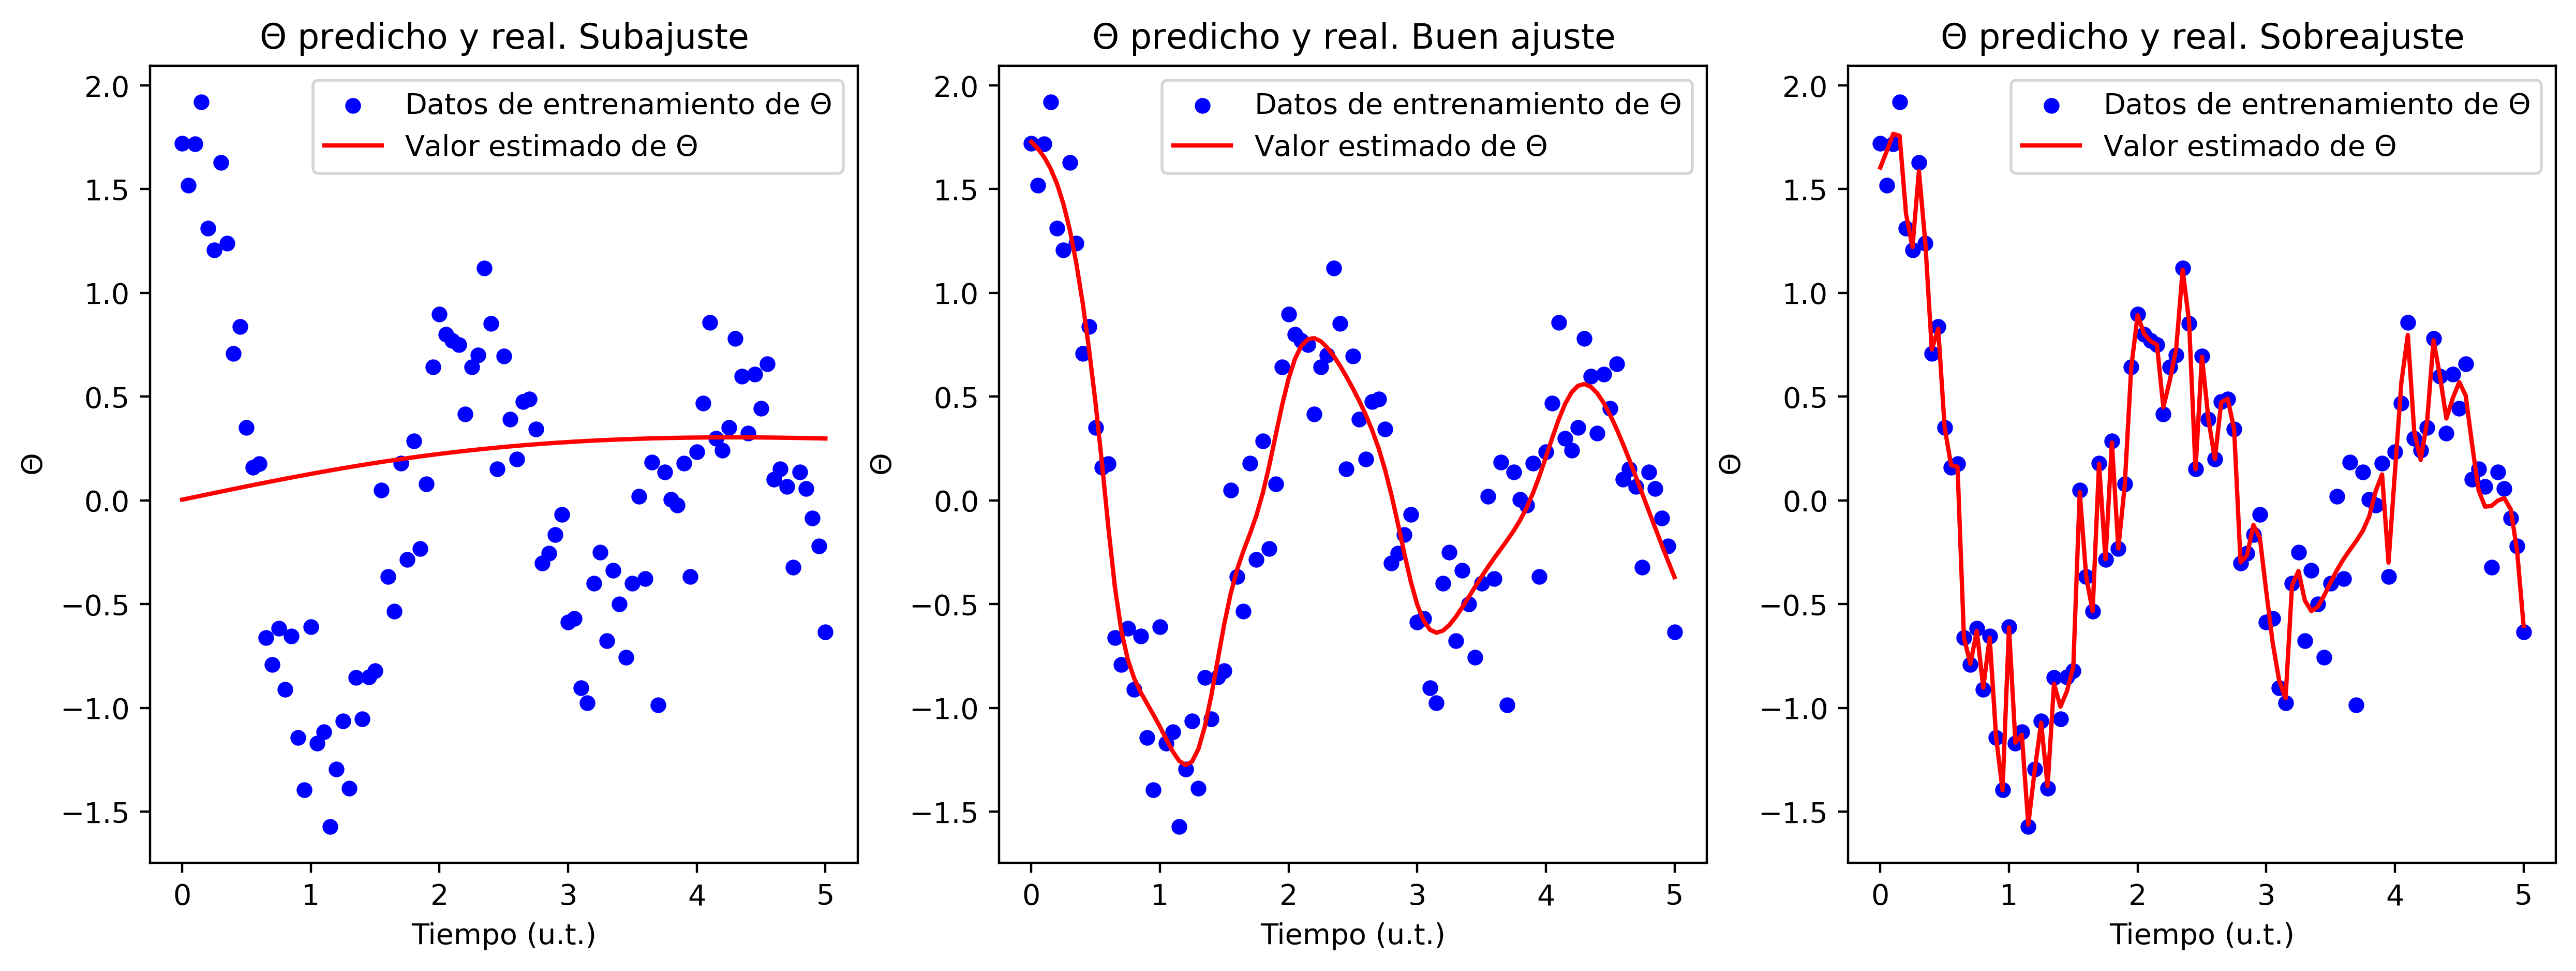

In [32]:
# Predict using the trained model
t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))
theta_pred_sin = model_nn_sin(t_tensor).numpy()
theta_pred_tanh = model_nn_tanh(t_tensor).numpy()
theta_pred_tanh_reg = model_nn_tanh_reg(t_tensor).numpy()

# Plot the results
plt.figure(figsize=(15, 5), dpi=400)
plt.subplot(1, 3, 1)
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, theta_pred_sin[:, 0], label=r'Valor estimado de $\Theta$', color='red')
plt.legend()
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.title(r'$\Theta$ predicho y real. Subajuste')

plt.subplot(1, 3, 2)
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, theta_pred_tanh_reg[:, 0], label=r'Valor estimado de $\Theta$', color='red')
plt.legend()
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.title(r'$\Theta$ predicho y real. Buen ajuste')

plt.subplot(1, 3, 3)
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, theta_pred_tanh[:, 0], label=r'Valor estimado de $\Theta$', color='red')
plt.legend()
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.title(r'$\Theta$ predicho y real. Sobreajuste')

plt.show()
